In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from torch_tools import *
from wrappers import *
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
T_trial = 100
task = Context_Dependent_Decision_Task(T_trial=T_trial, input_var=0.1, report_cue=True)

In [3]:
### --- UNPACK RESULTS --- ###

file_name = 'Figure5C_example_sd1_ctx0'
saved_run_name = file_name
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/home/om2382/learning-dynamics/results/PNAS_Paper'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices, checkpoints = unpack_analysis_results(analysis_result_path)
signals = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                             'n_nodes': get_checkpoint_n_stable_FPs,
                                                             'discriminant': get_checkpoint_cubic_discriminant,
                                                             'lengths': get_checkpoint_maximum_cluster_distances},
                                results_subdir='PNAS_Paper')

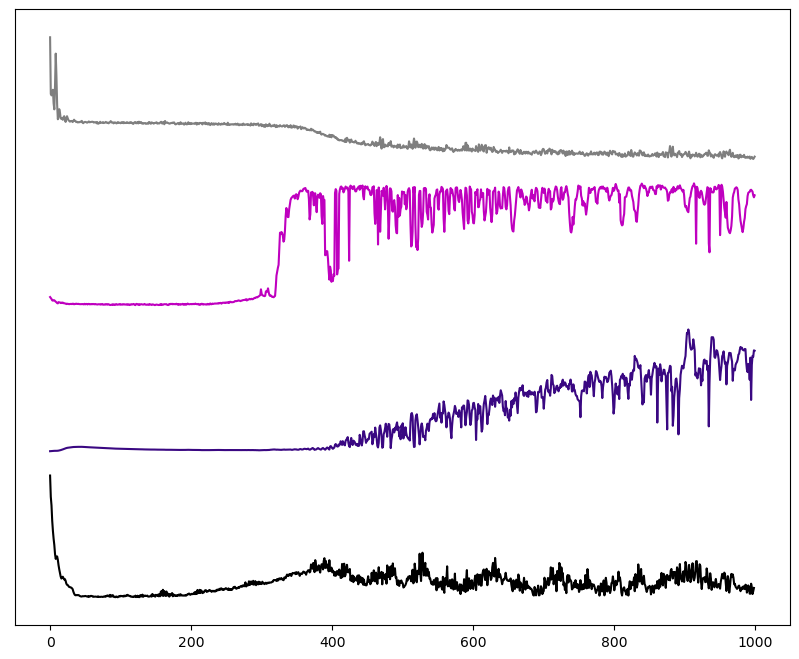

In [79]:
signals['d_loss'] = signals['test_loss'][1:] - signals['test_loss'][:-1]
fig = plot_signals(signals, x_values=indices, signal_clips={'test_loss': 1.2}, legend=False,
                   key_restriction=['test_loss', 'lengths', 'discriminant', 'rec_weight_distances'],
                   colors=['#7F7F7F', 'm', '#3A0882', 'k', '#8C564B'])
#for t in t_stage_transitions:
#    plt.axvline(x=t*10, linestyle='--', color=('0.8'))

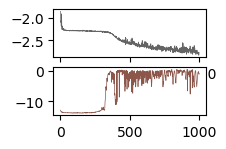

In [4]:
### --- FIGURE 5C --- ###

cm = 1/2.54
fig, ax = plt.subplots(2, 1, figsize=(5*cm, 3.5*cm))
ax[0].plot(indices, np.log10(signals['test_loss']), color='#646464', linewidth=0.5)
ax[1].plot(indices, signals['lengths'], color='#8C564B', linewidth=0.5)
#ax[0].axis('off')
#ax[1].axis('off')
#fig.savefig('figs/fig5c_dynamics.pdf', format='pdf')

(-49.85, 1046.85, -0.23062844434196075, 0.27866253411575215)

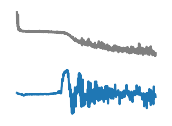

In [97]:
### --- FIGURE 5C WITH FILTERS --- ###

cm = 1/2.54
fig, ax = plt.subplots(2, 1, figsize=(5*cm, 3.5*cm))
ax[0].plot(indices, np.log10(signals['test_loss']), color='C7')
#ax[1].plot(indices, signals['lengths'], color='C3')

n_kernel = 50
y = signals['lengths'].copy()
y_clipped = y#np.clip(y, 0, 1.2)
y = np.concatenate([y_clipped[n_kernel-1:0:-1], y_clipped])
y = np.convolve(y, np.ones(n_kernel)/n_kernel, mode='valid')[:-1]
#ax[1].plot(indices[:-1], y, color='C3')
ax[1].plot(indices[:-2], y[1:] - y[:-1])
ax[0].axis('off')
ax[1].axis('off')
#fig.savefig('figs/fig5c_dynamics.pdf', format='pdf')

(-49.95, 1048.95, -14.538327100060943, 1.316434214423818)

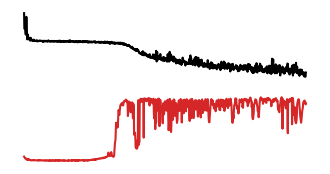

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(4, 2))
ax[0].plot(np.log10(signals['test_loss']), color='k')
ax[1].plot(signals['lengths'], color='C3')
ax[0].axis('off')
ax[1].axis('off')

In [9]:
hist = []
for i_cp in range(0, 2000, 1):
    cp = checkpoints['checkpoint_{}'.format(i_cp)]
    for i in range(len(set(cp['cluster_labels']))):
        #hist.append(cp['fixed_points'][np.where(cp['cluster_labels'] == i)].var(0).mean())
        distances = distance.pdist(cp['fixed_points'][np.where(cp['cluster_labels'] == i)], 'euclidean')
        try:
            max_distance = np.max(distances)
            hist.append(max_distance)
        except ValueError:
            pass

KeyboardInterrupt: 

In [6]:
i_cp = 500
data = task.gen_data(0, 1000)
cp = checkpoints['checkpoint_{}'.format(i_cp)]
rnn = cp['rnn']
probe_sim = Simulation(rnn)
probe_sim.run(data,
              mode='probe',
              monitors=['rnn.loss_', 'rnn.y_hat', 'rnn.a'],
              verbose=False)

M = np.concatenate([probe_sim.mons['rnn.a'], cp['fixed_points']], axis=0)
M = probe_sim.mons['rnn.a']
U, S, VT = np.linalg.svd(M)
proj = VT[:,:2]
proj = np.linalg.qr(np.random.normal(0, 1, (32, 32)))[0][:,:2]

all_lengths = []
for i_cp in range(1000):
    cp = checkpoints['checkpoint_{}'.format(i_cp)]
    lengths = []
    for i in range(len(set(cp['cluster_labels']))):
        fp = cp['fixed_points'][np.where(cp['cluster_labels'] == i)]
        if fp.size == 0:
            continue
        distances = distance.pdist(fp, 'euclidean')
        lengths.append(np.max(distances))
        #plt.plot(fp.dot(proj)[:,0],
        #         fp.dot(proj)[:,1], '.')
    lengths = sorted(lengths)[::-1]
    all_lengths.append(lengths)

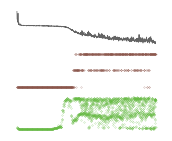

In [8]:
cm = 1/2.54
#fig, ax = plt.subplots(2, 1, figsize=(5*cm, 3.5*cm))
#ax[0].plot(indices, np.log10(signals['test_loss']), color='#646464', linewidth=0.5)
#ax[1].plot(indices, signals['lengths'], color='#8C564B', linewidth=0.5)

fig, ax = plt.subplots(3, 1, figsize=(5*cm, 4*cm))
for i, li in enumerate(all_lengths):
    
    A = np.concatenate([np.array([[i, np.log10(l)]]).reshape(1, -1) for l in li], axis=0)
    ax[2].plot(A[:,0], A[:,1], '.', color='#66BC42', markersize=0.3)
ax[1].plot(signals['n_nodes'], '.', color='#8C564B', markersize=0.3)
ax[0].plot(np.log10(signals['test_loss']), color='#646464', linewidth=0.5)
#ax[0].set_ylim([])
for i in range(3):
    ax[i].axis('off')
fig.savefig('figs/fig5c_dynamics_3.pdf', format='pdf')

In [19]:
### --- DETECT EVENTS --- ###

test_loss_threshold = -2.35
length_threshold = -11
node_threshold = 2

ignore_first = 50
loss_events = []
line_attractor_events = []
node_events = []
for i in [0]:
    append_loss = True
    append_line = True
    append_node = True
    for t in range(ignore_first, 1000):
        if np.log10(signals['test_loss'][t]) < test_loss_threshold and append_loss:
            loss_events.append(t)
            append_loss = False
        if signals['lengths'][t] > length_threshold and append_line:
            line_attractor_events.append(t)
            append_line = False
        if signals['n_nodes'][t] >= node_threshold and append_node:
            node_events.append(t)
            append_node = False

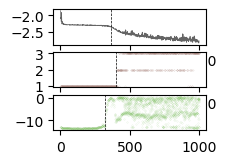

In [29]:
cm = 1/2.54
#fig, ax = plt.subplots(2, 1, figsize=(5*cm, 3.5*cm))
#ax[0].plot(indices, np.log10(signals['test_loss']), color='#646464', linewidth=0.5)
#ax[1].plot(indices, signals['lengths'], color='#8C564B', linewidth=0.5)

fig, ax = plt.subplots(3, 1, figsize=(5*cm, 4*cm))
for i, li in enumerate(all_lengths):
    
    A = np.concatenate([np.array([[i, np.log10(l)]]).reshape(1, -1) for l in li], axis=0)
    ax[2].plot(A[:,0], A[:,1], '.', color='#66BC42', markersize=0.3, alpha=0.3)
ax[1].plot(signals['n_nodes'], '.', color='#8C564B', markersize=0.3, alpha=0.3)
ax[0].plot(np.log10(signals['test_loss']), color='#646464', linewidth=0.5)
#ax[0].set_ylim([])
for i in range(3):
    pass
    #ax[i].axis('off')
ax[0].axvline(x=loss_events[0], color='k', linestyle='--', linewidth=0.5)
ax[1].axvline(x=node_events[0], color='k', linestyle='--', linewidth=0.5)
ax[2].axvline(x=line_attractor_events[0], color='k', linestyle='--', linewidth=0.5)
fig.savefig('figs/fig5c_dynamics_3_labels.pdf', format='pdf')

In [ ]:
!mkdir figs/image_stack_6

In [ ]:
for i_cp in range(1000, 1010):
    fig = plt.figure()
    cp = checkpoints['checkpoint_{}'.format(i_cp)]
    v = cp['V'][:,0]
    W = cp['rnn'].W_rec.copy()
    W_in = cp['rnn'].W_in.copy()

    for r_rot in np.arange(-8, 8, 0.1):
        #r_rot = 0
        alpha = 0.1
        x = []
        for i in range(400):

            r_rot = (1 - alpha)*r_rot + alpha * v.dot(np.tanh(W.dot(v) * r_rot + W_in.dot(np.eye(5)[2])))
            x.append(r_rot)
        plt.plot(x, color='C0', alpha=0.8)
    #fig.savefig('figs/image_stack_6/cp_{}.png'.format(i_cp), format='png')
    #plt.close()

In [ ]:
i_cp = 800
fig = plt.figure()
cp = checkpoints['checkpoint_{}'.format(i_cp)]
v = cp['V'][:,0]
W = cp['rnn'].W_rec.copy()
W_in = cp['rnn'].W_in.copy()
b_rec = cp['rnn'].b_rec.copy()

for r_rot in np.arange(-8, 8, 0.5):
    r = v * r_rot
    alpha = 0.1
    x = []
    x_real = []
    for i in range(400):

        r_rot = (1 - alpha)*r_rot + alpha * v.dot(np.tanh(W.dot(v) * r_rot + W_in.dot(np.eye(5)[2]) + b_rec))
        r = (1 - alpha)*r + alpha * np.tanh(W.dot(r) + W_in.dot(np.eye(5)[2]) + b_rec)
        x.append(r_rot)
        x_real.append(v.dot(r))
    plt.plot(x, color='C0', alpha=0.8)
    plt.plot(x_real, color='C1', alpha=0.8)

plt.legend(['1D approx', 'actual dynamics projected to 1D'])
plt.title('Checkpoint {}'.format(i_cp))

In [ ]:
### --- UNPACK RESULTS --- ###

file_name = 'BPTT_0_ctx0'
saved_run_name = file_name
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/home/om2382/learning-dynamics/results/misc'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices_0, checkpoints_0 = unpack_analysis_results(analysis_result_path)
signals_0 = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                               'n_nodes': get_checkpoint_n_stable_FPs,
                                                               'discriminant': get_checkpoint_cubic_discriminant,
                                                               'lengths': get_checkpoint_maximum_cluster_distances},
                                  results_subdir='misc')

In [ ]:
file_name = 'BPTT_0_ctx1'
saved_run_name = file_name
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/home/om2382/learning-dynamics/results/misc'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices_1, checkpoints_1 = unpack_analysis_results(analysis_result_path)
signals_1 = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                               'n_nodes': get_checkpoint_n_stable_FPs,
                                                               'discriminant': get_checkpoint_cubic_discriminant,
                                                               'lengths': get_checkpoint_maximum_cluster_distances},
                                  results_subdir='misc')

In [ ]:
i_cp = 2490
cp_0 = checkpoints_0['checkpoint_{}'.format(i_cp)]
cp_1 = checkpoints_1['checkpoint_{}'.format(i_cp)]

In [ ]:
colors = ['#0000FF', '#D62728']
col1 = '#FF0000'
col2 = '#0000FF'
col3 = '#00FF00'
col4 = '#FFFF00'
probe_colors = linearly_interpolate_colors(col1, col2, 10) + linearly_interpolate_colors(col3, col4, 10)
ssa = State_Space_Analysis(cp_0, data, n_PCs=2)
ssa = plot_checkpoint_results(cp_0, data, ssa,
                              plot_fixed_points=True,
                              plot_cluster_means=True,
                              plot_graph_structure=False,
                              plot_test_points=False,
                              n_test_samples=None,
                              T_per_sample=100,
                              test_alpha=1,
                              plot_probe=True,
                              n_probes=20,
                              probe_colors=probe_colors,
                              eig_norm_color=True,
                              graph_key='adjmat_input_1')
W_in_ = cp_0['rnn'].W_in[:,0]
W_out_ = cp_0['rnn'].W_out[0]
w_in = ssa.transform(W_in_)
w_in = w_in / norm(w_in)
w_out = ssa.transform(W_out_)
w_out = w_out / norm(w_out)
if True:
    ssa.ax.plot([-w_out[0], w_out[0]],
                [-w_out[1], w_out[1]], color='g', linewidth=2)
    window_size = 1.2
    
ssa = State_Space_Analysis(cp_0, data, n_PCs=2)
ssa = plot_checkpoint_results(cp_1, data, ssa,
                              plot_fixed_points=True,
                              plot_cluster_means=True,
                              plot_graph_structure=False,
                              plot_test_points=False,
                              n_test_samples=None,
                              T_per_sample=100,
                              test_alpha=1,
                              plot_probe=True,
                              n_probes=20,
                              probe_colors=probe_colors,
                              eig_norm_color=True,
                              graph_key='adjmat_input_1')
W_in_ = cp_1['rnn'].W_in[:,0]
W_out_ = cp_1['rnn'].W_out[0]
w_in = ssa.transform(W_in_)
w_in = w_in / norm(w_in)
w_out = ssa.transform(W_out_)
w_out = w_out / norm(w_out)
if True:
    ssa.ax.plot([-w_out[0], w_out[0]],
                [-w_out[1], w_out[1]], color='g', linewidth=2)
    window_size = 1.2

In [ ]:
np.std(cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 2)], axis=0).mean()

In [ ]:
line_FPs_0 = cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 2)]
distances_0 = distance.pdist(line_FPs_0, 'euclidean')

In [ ]:
M0 = distance.squareform(distances_0)
i_0_1, i_0_2 = np.where(M0 == np.max(M0))[0]

In [ ]:
r_0_1 = line_FPs_0[i_0_1]
r_0_2 = line_FPs_0[i_0_2]

In [ ]:
line_FPs_1 = cp_1['fixed_points'][np.where(cp_1['cluster_labels'] == 0)]
distances_1 = distance.pdist(line_FPs_1, 'euclidean')

In [ ]:
M1 = distance.squareform(distances_1)
i_1_1, i_1_2 = np.where(M1 == np.max(M1))[0]

In [ ]:
r_1_1 = line_FPs_1[i_1_1]
r_1_2 = line_FPs_1[i_1_2]

In [ ]:
def translate_fixed_point_across_contexts(cp, r_0):
    """Always from context 0 (known FP) to context 1 (unknown FP)"""
    
    W_rec = cp['rnn'].W_rec.copy()
    W_in = cp['rnn'].W_in.copy()
    b_rec = cp['rnn'].b_rec.copy()
    c_0 = np.eye(5)[2]
    c_1 = np.eye(5)[3]
    Delta_c = c_1 - c_0
    h_0 = W_rec.dot(r_0) + W_in.dot(c_0) + b_rec
    D = np.diag((1 - np.tanh(h_0)**2))
    Q = np.linalg.inv(np.eye(32) - D.dot(W_rec))
    Delta_r = Q.dot(D).dot(W_in.dot(Delta_c))
    
    return r_0 + Delta_r

In [ ]:
#plt.plot(r_0_1, color='C0')
#plt.plot(r_0_2, color='C0')
plt.plot(r_1_1, color='C1')
plt.plot(r_1_2, color='C1')
plt.plot(-0.2*translate_fixed_point_across_contexts(cp_0, r_0_1), color='C2')
plt.plot(-0.2*translate_fixed_point_across_contexts(cp_0, r_0_2), color='C2')

In [ ]:
plt.plot(W_rec.dot(translate_fixed_point_across_contexts(cp_0, r_0_1) - r_0_1) + W_in.dot(c_1 - c_0))

In [ ]:
i_cp = 2490
cp_0 = checkpoints_0['checkpoint_{}'.format(i_cp)]
cp_1 = checkpoints_1['checkpoint_{}'.format(i_cp)]
N_interp = 4

all_args = get_default_args()
all_args['FP_N'] = 500
all_args['FP_same_LR_criterion'] = 8000

k_interp = np.linspace(0, 1, N_interp+2)
interpolated_checkpoints = [cp_0]
for i in range(N_interp):
    cp = deepcopy(cp_0)
    k = k_interp[i+1]
    all_args['FP_context'] = k*np.eye(5)[3] + (1-k)*np.eye(5)[2]
    cp = analyze_individual_checkpoint(checkpoint=cp,
                                       task=task,
                                       data=data,
                                       all_args=all_args)
    interpolated_checkpoints.append(cp)
interpolated_checkpoints.append(cp_1)

In [ ]:
colors = ['#0000FF', '#D62728']
col1 = '#FF0000'
col2 = '#0000FF'
col3 = '#00FF00'
col4 = '#FFFF00'
probe_colors = linearly_interpolate_colors(col1, col2, 10) + linearly_interpolate_colors(col3, col4, 10)
for i in range(6):
    ssa = State_Space_Analysis(cp_0, data, n_PCs=2)
    ssa = plot_checkpoint_results(interpolated_checkpoints[i], data, ssa,
                              plot_fixed_points=True,
                              plot_cluster_means=True,
                              plot_graph_structure=False,
                              plot_test_points=False,
                              n_test_samples=None,
                              T_per_sample=100,
                              test_alpha=1,
                              plot_probe=True,
                              n_probes=20,
                              probe_colors=probe_colors,
                              eig_norm_color=False,
                              graph_key='adjmat_input_1')
    #window_size = 1.2
    #ssa.ax.set_ylim([-window_size, window_size])
    #ssa.ax.set_xlim([-window_size, window_size])